# R3R Validation

## Notebook Initialization

In [1]:
using Pkg;
Pkg.activate("..")

  Activating project at `~/Documents/repos/R3RDemo`
project at `~/Documents/repos/R3RDemo`


In [2]:
using Agents
using CairoMakie
using OrdinaryDiffEq, DiffEqCallbacks, LinearAlgebra, StaticArrays
using DataFrames

## 2D Double Integrators

First, model a system of the form:
$$
\begin{bmatrix}
    \dot{x}\\
    \dot{y}\\
    \ddot{x}\\
    \ddot{y}
\end{bmatrix} = 
\begin{bmatrix}
    \ddot{x}\\
    \ddot{y}\\
    u_x\\
    u_y
\end{bmatrix} 
$$

With state matrix $\begin{bmatrix}x & y & \dot x & \dot y\end{bmatrix}^T$ and control input $u = [u_x, u_y]$.

Going to let $\delta = 1$, $R_\text{comm} = 16 \implies R_\text{plan} = 5$

In [3]:
# DEFINE CONSTANTS
const DELTA::Float64 = 1.
const RCOMM::Float64 = 10.
# const RPLAN::Float64 = 5.
const VMAX::Float64 = 1.0
const T_WEIGHT::Float64 = 0.5

INITIAL_POSITIONS = [SVector{2, Float64}([5.0, 5.0]),
                     SVector{2, Float64}([16.0, 5.0]),
                     SVector{2, Float64}([5.0, 16.0]),
                     SVector{2, Float64}([16.0, 16.0])]


GOAL_POSITIONS = [SVector{2, Float64}([16.0, 16.0]),
                     SVector{2, Float64}([5.0, 16.0]),
                     SVector{2, Float64}([16.0, 5.0]),
                     SVector{2, Float64}([5.0, 5.0])]

# GOAL_POSITIONS = [SVector{2}([16.0, 5.0]),
#                   SVector{2}([5.0, 5.0])]


4-element Vector{SVector{2, Float64}}:
 [16.0, 16.0]
 [5.0, 16.0]
 [16.0, 5.0]
 [5.0, 5.0]

In [4]:
include("strrt_star.jl")
include("double_integrators_gatekeeper.jl")
include("2d_double_integrators.jl")

DI = double_integrators_2d

STRRT_STAR.init_planner(
    100,
    Float32(DELTA),
    Float32(VMAX),
    Float32(T_WEIGHT) 
)

model = DI.init_model(
    n_agents=4,
    delta=DELTA,
    Rcomm=RCOMM,
    seed=100,
    agent_starting_positions=INITIAL_POSITIONS,
    agent_goal_positions=GOAL_POSITIONS,
) # Create model with default params

# Step the model once
# step!(model, 2)

StandardABM with 4 agents of type DoubleIntegrator2D
 agents container: Dict
 space: continuous space with [100.0, 100.0] extent and spacing=5.0
 scheduler: fastest
 properties: Rcomm, Rplan, delta, Rgoal, v_max, u_max, dt, num_timesteps_before_replan

In [33]:
# step!(model, 10)
# fig, ax, abmobs = abmplot(model; agent_marker = double_integrators_2d.plot_agent)
# fig, ax, abmobs = abmplot(model; agent_marker = double_integrators_2d.plot_agent, agent_color = double_integrators_2d.agent_color)
# double_integrators_2d.plot_model_extras!(ax, model)

# fig.title = "Double Integrators 2D t=$(abmtime(model))"
# fig.xlabel = "X"
# fig.ylabel = "Y"

# save("double_integrators_2d_test_6.png", fig)
# fig

agent_data = [:pos]
till_done = (model_in, t) -> nagents(model_in) == 0 || t > 20.0
agent_df, model_df = run!(model, till_done; adata=agent_data)

Agent 4 step at time 18.900000000000002


UndefVarError: UndefVarError: `unset_start_value` not defined in `Main.Gatekeeper2D`
Suggestion: check for spelling errors or missing imports.

### Animate the Data from Run!

In [32]:
# Create animation from agent_df
fig = Figure()
ax = Axis(fig[1, 1], xlabel = "X", ylabel = "Y", title = "Agent Trajectories")

# Get unique time steps and agent IDs
unique_times = unique(agent_df.time)
unique_agents = unique(agent_df.id)
n_agents = length(unique_agents)

# Set up axis limits
xlims!(ax, 0, 20)
ylims!(ax, 0, 20)  # Increased to accommodate 4 agents

# Define colors for agents
colors = [:orange, :blue, :red, :green, :purple, :brown, :pink, :gray, :olive, :cyan]

# Create observables for animation - dynamically for all agents
agent_positions = [Observable(Point2f[]) for _ in 1:n_agents]
current_agents = [Observable(Point2f(0, 0)) for _ in 1:n_agents]

# Create circles around agents (radius = 1.0)
circle_points = 50
θ = range(0, 2π, length=circle_points)
unit_circle_x = cos.(θ)
unit_circle_y = sin.(θ)

# Create observables for circle positions
agent_circles = [Observable([Point2f(x, y) for (x, y) in zip(unit_circle_x, unit_circle_y)]) for _ in 1:n_agents]

# Plot trajectories, current positions, and circles for all agents
for i in 1:n_agents
    agent_color = colors[mod1(i, length(colors))]
    
    # Plot trajectory
    lines!(ax, agent_positions[i], color = agent_color, linewidth = 2, label = "Agent $i")
    
    # Plot current position
    scatter!(ax, current_agents[i], color = agent_color, markersize = 4)
    
    # Plot circle around agent
    lines!(ax, agent_circles[i], color = agent_color, linewidth = 1, alpha = 0.5, linestyle = :dash)
end

axislegend(ax, position = :lt)

# Animate
record(fig, "agent_animation.gif", unique_times; framerate = 10) do t
    # Get data for current time
    current_data = filter(row -> row.time == t, agent_df)
    
    if nrow(current_data) >= 1
        # Update trajectories and positions for each agent
        for i in 1:n_agents
            agent_id = unique_agents[i]
            
            # Update trajectory up to current time
            agent_data = filter(row -> row.id == agent_id && row.time <= t, agent_df)
            if nrow(agent_data) > 0
                agent_positions[i][] = [Point2f(pos[1], pos[2]) for pos in agent_data.pos]
            end
            
            # Update current position with bounds checking
            agent_current = filter(row -> row.id == agent_id, current_data)
            if nrow(agent_current) > 0 && length(agent_current.pos[1]) >= 2
                agent_center = Point2f(agent_current.pos[1][1], agent_current.pos[1][2])
                current_agents[i][] = agent_center
                
                # Update circle position around agent
                agent_circles[i][] = [Point2f(agent_center[1] + x, agent_center[2] + y) for (x, y) in zip(unit_circle_x, unit_circle_y)]
            end
        end
    end
end


"agent_animation.gif"

In [34]:
# all_agent_dfs = []
push!(all_agent_dfs, agent_df)

8-element Vector{Any}:
 88×3 DataFrame
 Row │ time   id     pos                
     │ Int64  Int64  SArray…            
─────┼──────────────────────────────────
   1 │    42      1  [7.18781, 7.03493]
   2 │    42      2  [13.9549, 7.19473]
   3 │    42      3  [7.40159, 14.2071]
   4 │    42      4  [13.8384, 13.9284]
   5 │    43      1  [7.25338, 7.11044]
   6 │    43      2  [13.8852, 7.26641]
   7 │    43      3  [7.47796, 14.1426]
   8 │    43      4  [13.7678, 13.8576]
  ⋮  │   ⋮      ⋮            ⋮
  82 │    62      2  [12.9615, 8.18102]
  83 │    62      3  [8.48585, 13.322]
  84 │    62      4  [12.844, 12.943]
  85 │    63      1  [8.19105, 8.1497]
  86 │    63      2  [12.8897, 8.2507]
  87 │    63      3  [8.56505, 13.2609]
  88 │    63      4  [12.7734, 12.8721]
                         73 rows omitted
 88×3 DataFrame
 Row │ time   id     pos                
     │ Int64  Int64  SArray…            
─────┼──────────────────────────────────
   1 │    63      1  [8.19105, 8

In [31]:
# Combine the data from all_agent_dfs into a single DataFrame
agent_df = vcat(all_agent_dfs...)


Row,time,id,pos
,Int64,Int64,SArray…
1,42,1,"[7.18781, 7.03493]"
2,42,2,"[13.9549, 7.19473]"
3,42,3,"[7.40159, 14.2071]"
4,42,4,"[13.8384, 13.9284]"
5,43,1,"[7.25338, 7.11044]"
6,43,2,"[13.8852, 7.26641]"
7,43,3,"[7.47796, 14.1426]"
8,43,4,"[13.7678, 13.8576]"
9,44,1,"[7.31896, 7.18593]"


## Test the Nominal Trajectory Generation & Tracking

In [ ]:
include("strrt_star.jl")
include("double_integrators_gatekeeper.jl")
using .Gatekeeper2D

nominal_path = [100.0 100.0 √20000.0;
    100.0 200.0 √20000.0 + 100.0;
    0.0 0.0 2*√20000.0 + 200.0;]

x0 = [0.0, 0.0]
tspan = (0.0, nominal_path[end, 3])

termination_callback = ContinuousCallback((state, t, i) -> norm(state[1:2] - x0) - 20.0, Gatekeeper2D.terminate!)

odeproblem = ODEProblem(Gatekeeper2D.closed_loop_tracking_nominal!, [0.0, 0.0, 0.0, 0.0], tspan, (nothing, nominal_path))
# odesol = solve(odeproblem, Tsit5(), callback=termination_callback)
odesol = solve(odeproblem, Tsit5(), dt=0.05, dtmax=0.1)#, callback=termination_callback)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 4833-element Vector{Float64}:
   0.0
   0.05
   0.15000000000000002
   0.25
   0.35
   0.44999999999999996
   0.5499999999999999
   0.6499999999999999
   0.7499999999999999
   0.8499999999999999
   ⋮
 482.06318111420404
 482.16318111420406
 482.2631811142041
 482.3631811142041
 482.46318111420413
 482.56318111420416
 482.6631811142042
 482.7631811142042
 482.842712474619
u: 4833-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0]
 [0.0008838834764831667, 0.0008838834764831667, 0.035355339059327355, 0.035355339059327355]
 [0.007954951288348623, 0.007954951288348623, 0.1060660171779821, 0.1060660171779821]
 [0.02209708691207956, 0.02209708691207956, 0.17677669529663687, 0.17677669529663687]
 [0.043310290347675966, 0.043310290347675966, 0.2474873734152916, 0.2474873734152916]
 [0.07159456159513779, 0.07159456159513779, 0.31819805153394637, 0.31819805153394637]
 [0.1069499006544651, 0.1069499006544651, 0.38890

### Plot the Solution

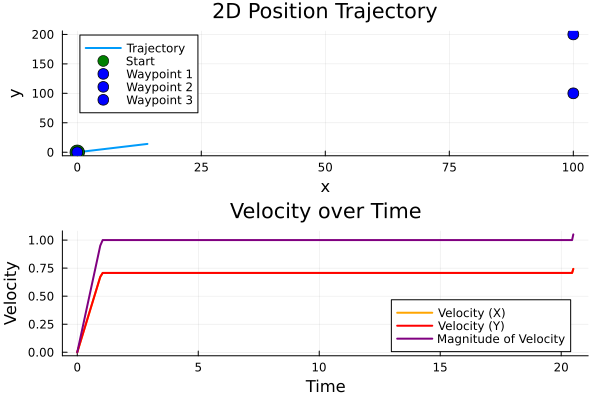

In [110]:
# Plot the position in 2D
p1 = plot(odesol[1,:], odesol[2,:], label="Trajectory", linewidth=2)
scatter!([x0[1]], [x0[2]], label="Start", markersize=8, color=:green)
for i in 1:size(nominal_path, 1)
    scatter!([nominal_path[i,1]], [nominal_path[i,2]], label="Waypoint $i", markersize=6, color=:blue)
end

xlabel!("x")
ylabel!("y")
title!("2D Position Trajectory")

# Plot the velocity over time
p2 = plot(odesol.t, odesol[3,:], label="Velocity (X)", linewidth=2, color=:orange)
plot!(odesol.t, odesol[4,:], label="Velocity (Y)", linewidth=2, color=:red)
plot!(odesol.t, sqrt.(odesol[3,:].^2 .+ odesol[4,:].^2), label="Magnitude of Velocity", linewidth=2, color=:purple)
xlabel!("Time")
ylabel!("Velocity")
title!("Velocity over Time")

plot(p1, p2, layout=(2,1))



In [15]:
include("double_integrators_gatekeeper.jl")
using .Gatekeeper2D
GK = Gatekeeper2D


Main.Gatekeeper2D

In [1]:
const LIB_PATH = "./ompl_src/build/libompl_src.dylib"

ccall((:init, LIB_PATH), Cvoid,
    (Cint, Cfloat, Cfloat, Cfloat),
    100.0, 5.0, 1.0, 0.5)

### construct_backup_trajectory Testing

In [21]:
using OrdinaryDiffEq, DiffEqCallbacks, LinearAlgebra
include("double_integrators_gatekeeper.jl")
using .Gatekeeper2D
GK = Gatekeeper2D

end_time = 20.0
t_guess = 19.0

x0 = [0.0, 0.0, 0.0, 0.0]
backup_set = [0.0, 5.0, 0.0, 0.0]

function pos_at_t(t)
    return [0.0, 5.0 * (t - 5.0) / (15.0), 0.0, 1.0]
end

function success_condition(state, time, integrator)
    return 0.05 - norm(state - backup_set)
end
function failure_condition(state, time, integrator)
    return 5.0 - norm(state[1:2] - x0[1:2])
end

success_callback = ContinuousCallback(success_condition, terminate!)
failure_callback = ContinuousCallback(failure_condition, terminate!)
callback_set = CallbackSet(success_callback, failure_callback)

successful = false
while !successful && t_guess > 5.0
    println("\t\tt_guess = $(t_guess)")
    pos_at_t_guess = pos_at_t(t_guess)

    odeproblem = ODEProblem(Gatekeeper2D.backup_mpc_controller!, pos_at_t_guess, (t_guess, end_time + 10.0), (nothing, backup_set))
    odesol = solve(odeproblem, Tsit5(), dt=0.05, dtmax=0.05, callback=callback_set) # TODO dt is hyperparam

    println("\t\tTerminated at t=$(odesol.t[end]) with state $(odesol[end])")

    # Check if was successful
    if norm(odesol[end] - backup_set) <= 0.1
        println("\t\tSuccess!")
        # Success condition was met
        t_switch = t_guess
        backup_trajectory = odesol
        successful = true
    else
        t_guess = t_guess - 10 * model.dt
    end
end



		t_guess = 19.0


		Terminated at t=19.422597949610587 with state [-8.496883610454179e-19, 4.999999999999999, -3.722894992603896e-17, 0.5776871551820405]
		t_guess = 18.0
		Terminated at t=19.441425076566272 with state [1.1920055207942173e-17, 4.985803301711351, -9.08971296912492e-18, 0.04794219183246726]
		Success!


## Testing w/Warm Starting

### Initialization

In [61]:
include("strrt_star.jl")
include("double_integrators_gatekeeper.jl")
using .Gatekeeper2D
using .STRRT_STAR

In [31]:
@kwdef struct DummyModel
    delta::Float64 = 1.0
    Rplan::Float64 = 5.0
    dummy_time::Float64 = 0.0
    dt::Float64 = 0.1
end

Agents.abmtime(model::DummyModel)::Float64 = model.dummy_time

@kwdef struct DummyAgent
    pos::SVector{2, Float64}
    vel::SVector{2, Float64}
    goal::SVector{2, Float64}
end

DummyAgent

### RUN EVERYTHING

In [86]:
t0 = 5.0
x0 = SVector{3, Float64}(4.0, 4.0, t0)
xg = SVector{2, Float64}(10.0, 10.0)

dummy_model = DummyModel(delta=1.0, Rplan=5.0, dummy_time=t0)
dummy_agent = DummyAgent(pos=SVector{2, Float64}(4.0, 4.0), vel=SVector{2, Float64}(0.0, 0.0), goal=xg)

DummyAgent([4.0, 4.0], [0.0, 0.0], [10.0, 10.0])

#### Plan Nominal

In [87]:
neighbor_trajectories = Gatekeeper2D.CompositeTrajectory[]
nominal_trajectory = plan_nominal(x0, xg, Gatekeeper2D.make_valid_function(neighbor_trajectories, dummy_model))

Info:    SpaceTimeRRT: Starting planning with 1 states already in datastructure
Info:    SpaceTimeRRT: Starting planning with time bound factor 2.00
Debug:   CostConvergenceTerminationCondition: Cost of optimizing planner converged after 10 solutions
Info:    SpaceTimeRRT: Created 4661 states (11 start + 4650 goal)


3×4 view(::Matrix{Float64}, :, 1:4) with eltype Float64:
 4.0  6.49657   9.65554  10.0
 4.0  6.52422   9.69718  10.0
 5.0  8.55188  13.0306   13.4892

#### Plot Nominal

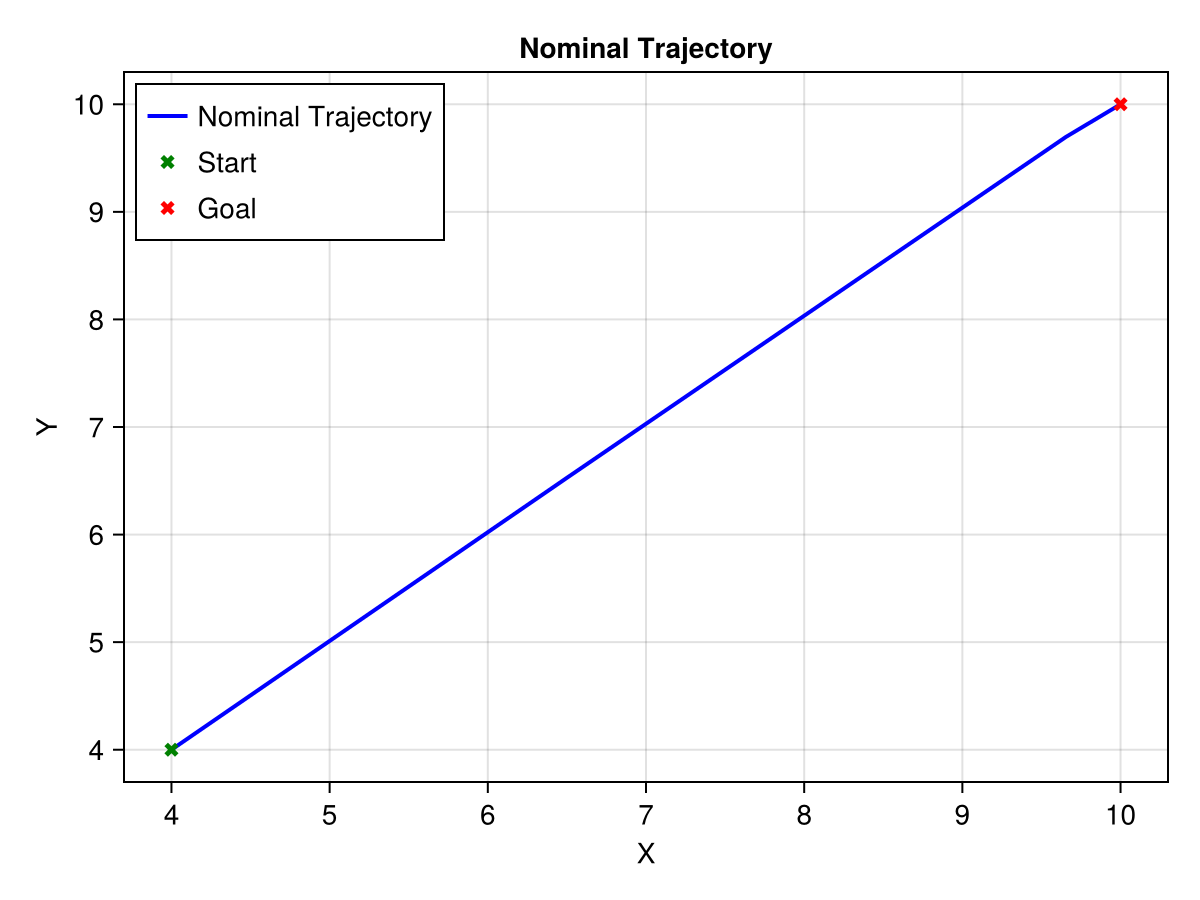

In [88]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel = "X", ylabel = "Y", title = "Nominal Trajectory")

# Extract x and y coordinates from the nominal trajectory
x_coords = [point[1] for point in eachcol(nominal_trajectory)]
y_coords = [point[2] for point in eachcol(nominal_trajectory)]

# Plot the trajectory
lines!(ax, x_coords, y_coords, color = :blue, linewidth = 2, label = "Nominal Trajectory")

# Plot start and goal points
scatter!(ax, [x0[1]], [x0[2]], color = :green, marker = :x, markersize = 10, label = "Start")
scatter!(ax, [xg[1]], [xg[2]], color = :red, marker = :x, markersize = 10, label = "Goal")

axislegend(ax, position = :lt)
fig

#### Plot the Planning Radius Around x0

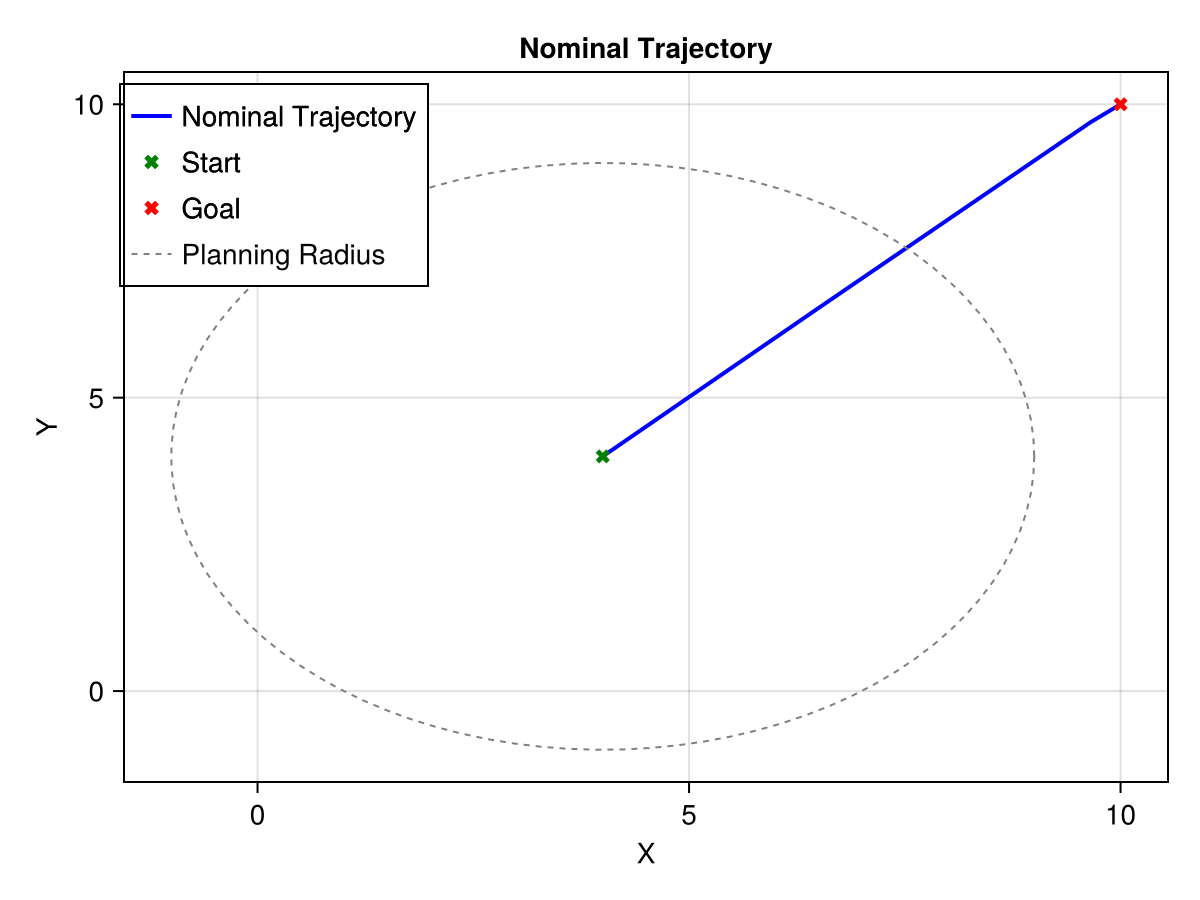

In [89]:
# Plots a dashed circle of radius Rplan around x0
circle_points = 100
θ = range(0, 2π, length=circle_points)
circle_x = x0[1] .+ dummy_model.Rplan .* cos.(θ)
circle_y = x0[2] .+ dummy_model.Rplan .* sin.(θ)

lines!(ax, circle_x, circle_y, color = :gray, linestyle = :dash, linewidth = 1, label = "Planning Radius")

# Update the legend
axislegend(ax, position = :lt)
fig


#### Track the Nominal Using Tracking Controller

In [90]:
tracked_nominal = Gatekeeper2D.forward_propagate_tracking_controller(dummy_agent, dummy_model, nominal_trajectory)

		forward_propagate_tracking_controller()
			Nominal Trajectory End Time: 13.4891632232179


retcode: Terminated
Interpolation: specialized 4th order "free" interpolation
t: 116-element Vector{Float64}:
  5.0
  5.00395641252534
  5.005661144204648
  5.022708460997734
  5.072708460997734
  5.122708460997734
  5.172708460997733
  5.222708460997733
  5.272708460997733
  5.322708460997733
  ⋮
 10.193819372730381
 10.243819372730382
 10.293819372730383
 10.343819372730383
 10.393819372730384
 10.443819372730385
 10.493819372730385
 10.500219343498468
 10.500219343498468
u: 116-element Vector{Vector{Float64}}:
 [4.0, 4.0, 0.0, 0.0]
 [4.000004441896445, 4.000004491103056, 0.0025137848939834765, 0.0025416321968087944]
 [4.000009749015069, 4.000009857013081, 0.003712554051561058, 0.003753681125391688]
 [4.000175217088052, 4.000177158114638, 0.015700245627336882, 0.01587417041122063]
 [4.001839230719109, 4.001859605419793, 0.05086029961494736, 0.05142372179500486]
 [4.005261247049547, 4.005319530294138, 0.08602035360255786, 0.08697327317878908]
 [4.010441266079365, 4.010556932737671, 0.

#### Plot the Tracked Nominal Ontop of the True Nominal

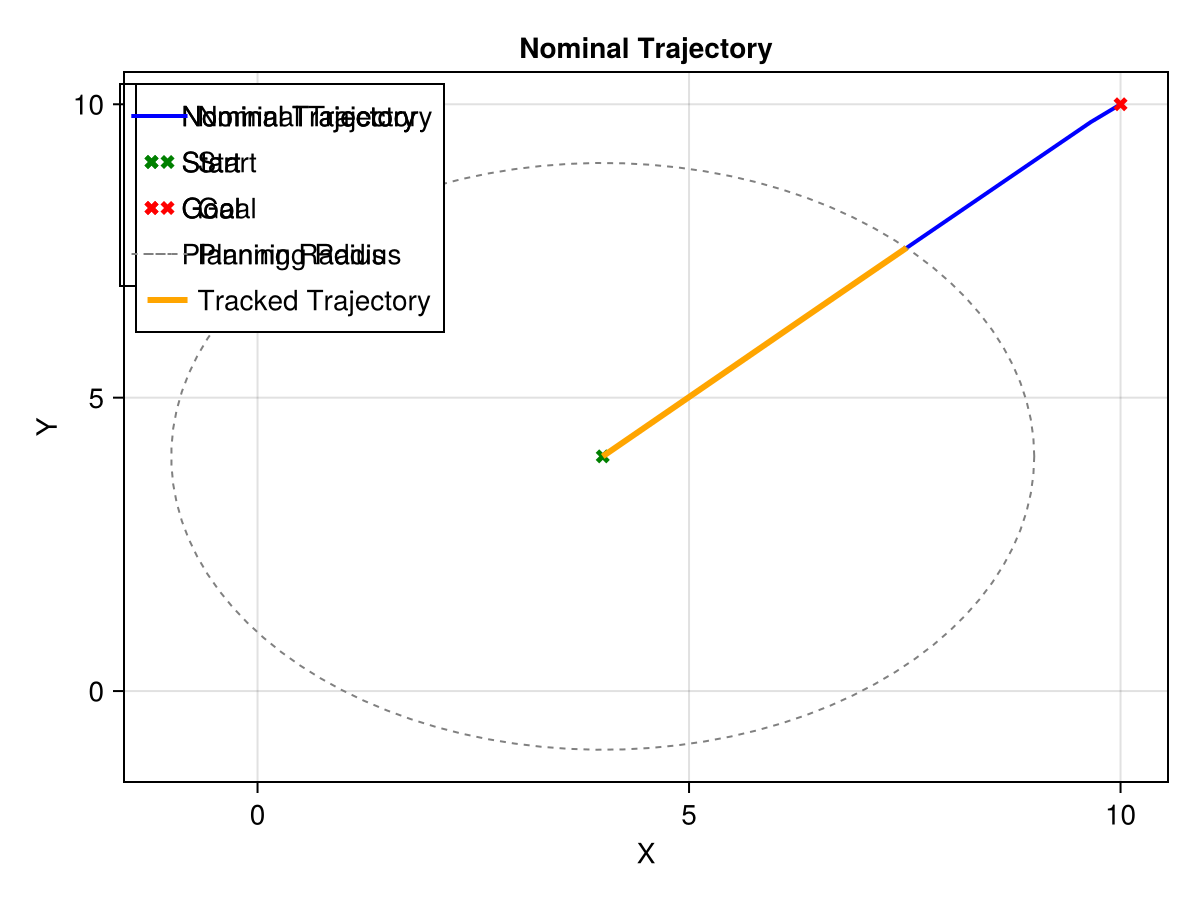

In [91]:
# Plot the tracked_nominal ontop of fig
# tracked_nominal is an odesol

# Extract x and y coordinates from the tracked nominal trajectory
tracked_x_coords = tracked_nominal[1, :]
tracked_y_coords = tracked_nominal[2, :]

# Add the tracked trajectory to the existing plot
lines!(ax, tracked_x_coords, tracked_y_coords, color = :orange, linewidth = 3, label = "Tracked Trajectory")

# Update the legend
axislegend(ax, position = :lt)
fig


#### Chose the Backup Set

In [92]:
backup_set = Gatekeeper2D.choose_backup_set(dummy_agent, dummy_model, tracked_nominal)

Had to decrease exit time


4-element Vector{Float64}:
 7.448193661608366
 7.4813737362250565
 0.0
 0.0

#### Plot the Backup Set

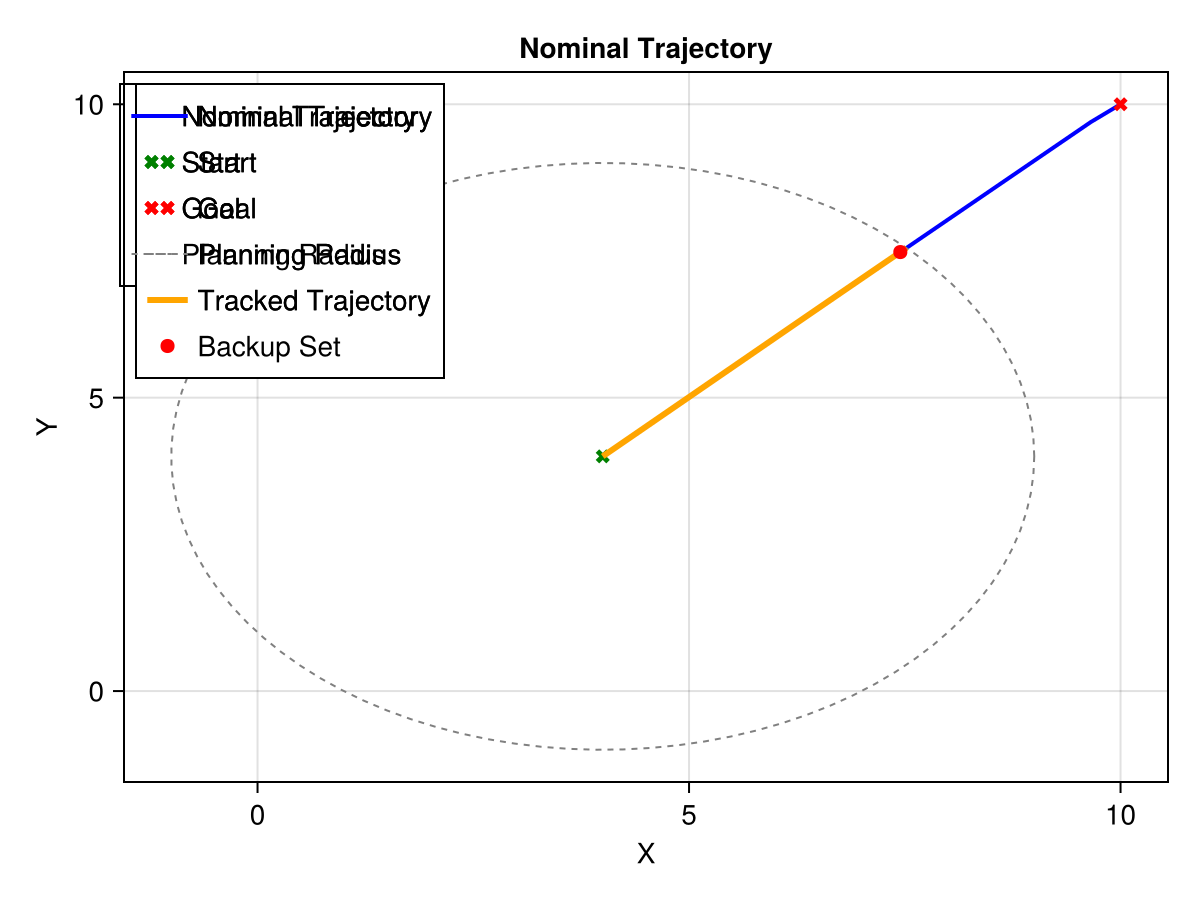

In [93]:
scatter!(ax, [backup_set[1]], [backup_set[2]], color = :red, markersize = 10, label = "Backup Set")

# Update the legend
axislegend(ax, position = :lt)
fig

#### Construct the Backup Trajectory

In [94]:
switch_time, backup_trajectory = Gatekeeper2D.construct_backup_trajectory(
    dummy_agent,
    dummy_model,
    tracked_nominal,
    backup_set
)

		construct_backup_trajectory
		Backup Set: [7.448193661608366, 7.4813737362250565, 0.0, 0.0]
		t_guess = 10.400219343498469, starting_pose = [7.448193661608366, 7.4813737362250565, 0.7098610973832395, 0.713398991065592]
		Terminated at t=10.50578553738503 with state [7.518755727265317, 7.552232837503411, 0.6312387353578501, 0.6338594452060271]
		Norm between final and goal: 0.9001334093548702
		t_guess = 10.300219343498469, starting_pose = [7.377661435737941, 7.410485055114233, 0.7098107931190408, 0.7134490419513588]
		Terminated at t=10.525466520117863 with state [7.518755567092075, 7.552232996167134, 0.5478162769388643, 0.5498351543908281]
		Norm between final and goal: 0.9001334093548702
		t_guess = 10.300219343498469, starting_pose = [7.377661435737941, 7.410485055114233, 0.7098107931190408, 0.7134490419513588]
		Terminated at t=10.525466520117863 with state [7.518755567092075, 7.552232996167134, 0.5478162769388643, 0.5498351543908281]
		Norm between final and goal: 0.782573566834

(9.90021934349847, ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{Float64}}}, Nothing, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Tuple{DummyAgent, Vector{Float64}}, ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, Tuple{DummyAgent, Vector{Float64}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Tuple{DummyAgent, Vector{Float64}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, Tuple{DummyAgent, Vector{Float64}}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDi

#### Plot the Backup Trajectory

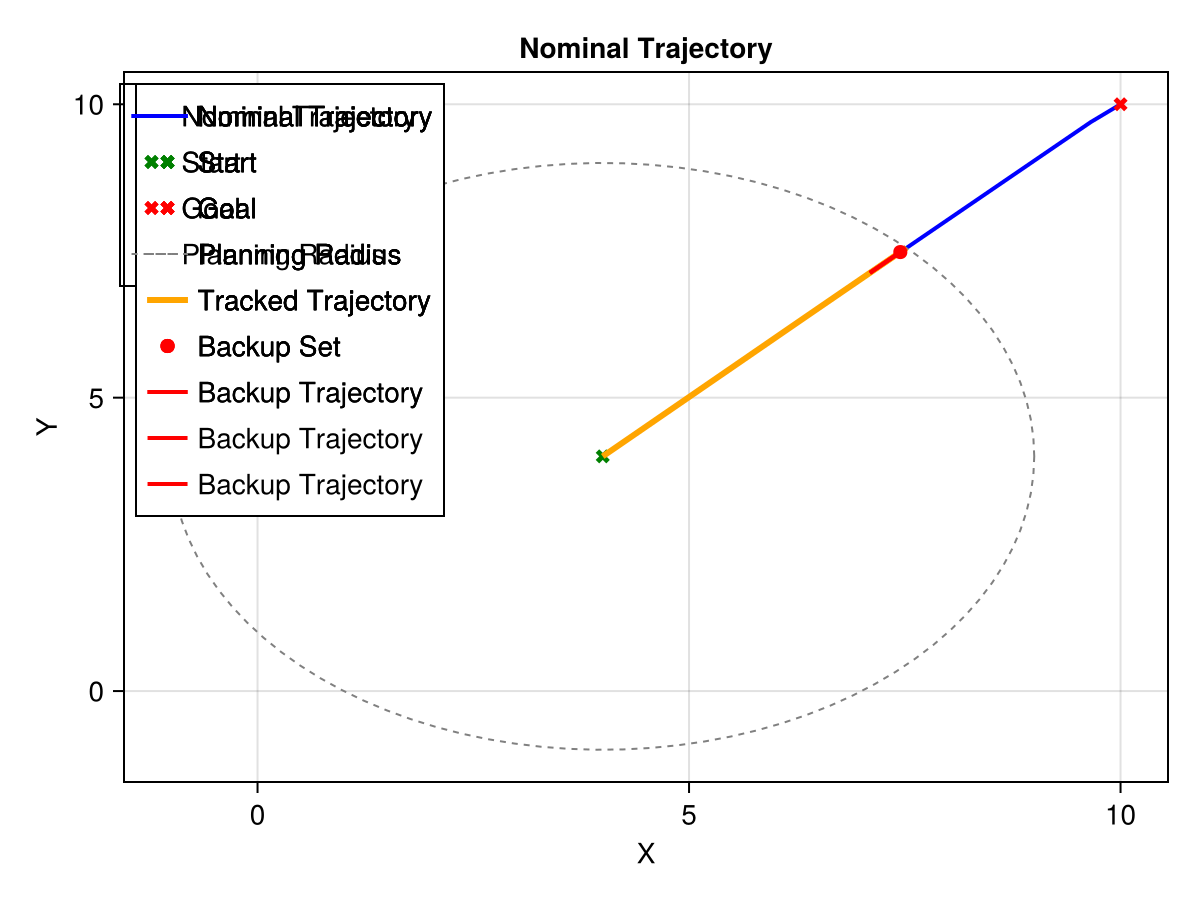

In [99]:
# Extract x and y coordinates from the tracked nominal trajectory
backup_x_coords = backup_trajectory[1, :]
backup_y_coords = backup_trajectory[2, :]

# Add the tracked trajectory to the existing plot
lines!(ax, backup_x_coords, backup_y_coords, color = :red, linewidth = 2, label = "Backup Trajectory")

# Update the legend
# No need to delete - just update the legend
axislegend(ax, position = :lt)
fig


In [96]:
print_mpc_stats()

No MPC statistics available
